# GEOG 5160 6160 Lab 07

# Introduction

For the next few labs, we'll be looking at deep learning models. As these are computationally costly models, they are generally built using specialized software to make them as efficient as possible. The full software stack consists of:

-   The backend deep learning software. This includes **tensorflow**, **torch** and **jax**.
-   The **keras** API. This is written in Python and tries to act as a unified interface to the different types of software

This offers a great amount of flexibility. If you want to develop very complex models, you can work directly with the deep learning package. If you need only to use standard functions, then you can use **keras**, and you can also set this to use a different backend. 

We'll mainly be using a combination of **keras** and **tensorflow** in this class, so the goals of this lab are to introduce these are get them running with a couple of simple examples. The code shown here borrows heavily from Deep Learning with Python (3rd edition) by Chollet et al. 


## Objectives

-   Set up **keras** and **tensorflow** on your computer
-   Understand the basic operations in a neural network
-   Build a simple classification model using standard network layers
-   Train and evaluate this model

# Installation

Installing deep learning software can be quite complicated. The backend software is in continual and rapid development, so that the libraries change often. In addition, these often are set up to use any available GPU power rather than (or in addition to) CPU power, and this usually requires an extra step of installing drivers for this. Here, we'll try to use the simplest approach, which is to create a new environment (if you are using virtual environments), and use `pip` to install the necessary packages. 

### Conda 

If you are using `conda` as an environment manager, open a terminal and create a new environment:

```
conda create -n tf-5160 python=3.12
```

Then activate this to start the environment

```
conda activate tf-5160
```

In this class, we'll be using **tensorflow** as the backend for our labs, so use `pip` now to install this (this will install the correspoding version of **keras** with it)

```
pip install tensorflow
```

You'll also need the following packages, so again, use `pip` to install these

- **pandas**
- **matplotlib**

# **Tensorflow**

## Tensors

Let's start by looking at the building blocks of these networks, *tensors*. This is the standard data object, and describes an array of numbers with a certain number of dimensions. If that sounds a lot like matrices and arrays, it is because this is just a highly efficient way of storing these. Start by loading the libraries:

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

np.random.seed(42)

Now we can make a simple 2D tensor with 2 rows and 3 columns as follows. This uses NumPy's `array` function to create the data, then converts it to a tensor:

In [66]:
np_array = np.array([[1, 2, 3], [4, 5, 6]])
tf_tensor = tf.convert_to_tensor(np_array)

And here's a 1D tensor

In [67]:
np_array = np.array([[1, 2, 3, 4]])
tf.convert_to_tensor(np_array)

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[1, 2, 3, 4]])>

And a 3D tensor

In [68]:
np_array = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
tf.convert_to_tensor(np_array)

<tf.Tensor: shape=(2, 2, 3), dtype=int64, numpy=
array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])>

You can use a lot of the basic Python functions with these. For example, to see the size of the 2D tensor

In [69]:
tf_tensor.shape

TensorShape([2, 3])

You can also add two tensors (as long as they have the same shape)

In [70]:
tf_tensor + tf_tensor

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]])>

In [71]:
tf.constant([1, 2, 3], dtype="float32")

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

There are also functions to create tensors with specific values. These functions make tensors of `1`s and `0`s:

In [72]:
tf.ones(shape=(2, 1))
tf.zeros(shape=(2, 1))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>

And these make tensors filled with random values (from normal or uniform distributions)

In [73]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)


tf.Tensor(
[[ 0.17806838]
 [-1.4704866 ]
 [-0.44262803]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.5872127]
 [0.5352808]
 [0.50738  ]], shape=(3, 1), dtype=float32)


**tensorflow** also defines a `Variable` data type:

In [74]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.6943327 ],
       [-0.1153608 ],
       [-0.74815184]], dtype=float32)>


While this will look a lot like a tensor, this is used to store values that change during training including model weights and parameters


## Basic operations

**tensorflow** comes with a lot of basic math functions. Let's start by creating a 2D random tensor:


In [75]:
x = tf.random.normal(shape=(2, 3), mean=10., stddev=1.)
print(x)

tf.Tensor(
[[10.35047   9.477856  9.745391]
 [ 8.387223 10.335032  9.52692 ]], shape=(2, 3), dtype=float32)


Then we can calculate the square or square root:

In [76]:
tf.square(x)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[107.13222,  89.82975,  94.97264],
       [ 70.34551, 106.8129 ,  90.76221]], dtype=float32)>

In [77]:
tf.sqrt(x)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.2172146, 3.0786126, 3.1217608],
       [2.8960702, 3.2148144, 3.086571 ]], dtype=float32)>

There are also specific functions that are key to train a neural network. You might recall from the lecture that there are three main calculation steps. 

In the forward pass, the output of every neuron in the network is calculated as the weighted sum of the inputs, plus a bias term $y = W \cdot x + b$. The first part of this equation is the dot product of two matrices, the array of weights ($W$) and the input values ($x$). In tensorflow, this calculated using the `matmul` function.

For example, here we create tensors of weights and random input values and multiply them together:

In [78]:
W = tf.Variable(initial_value=tf.random.normal(shape=(2, 2)))
print(W)

x = tf.random.normal(shape=(2, 2), mean=0., stddev=1.)
print(x)

tf.matmul(x,W)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-1.1113199 , -0.6768876 ],
       [-0.03976888, -1.494224  ]], dtype=float32)>
tf.Tensor(
[[-0.60713595  1.2879491 ]
 [ 0.10876697 -0.81658864]], shape=(2, 2), dtype=float32)


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.62350196, -1.5135216 ],
       [-0.08840008,  1.1465433 ]], dtype=float32)>

If we also create a *bias* (a constant additive term), we can create the basic weighted sum

In [79]:
b = tf.Variable(initial_value=tf.constant(1., shape=(2)))
print(b)

tf.matmul(x, W) + b


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 1.623502  , -0.51352155],
       [ 0.91159993,  2.1465433 ]], dtype=float32)>

2. Activation function. The next step in the forward pass is to send the output of node (above) through an activation function. There are several of these, and the code below simply illustrates how they convert a vector of randomly generated values (`x`)

- Linear activation

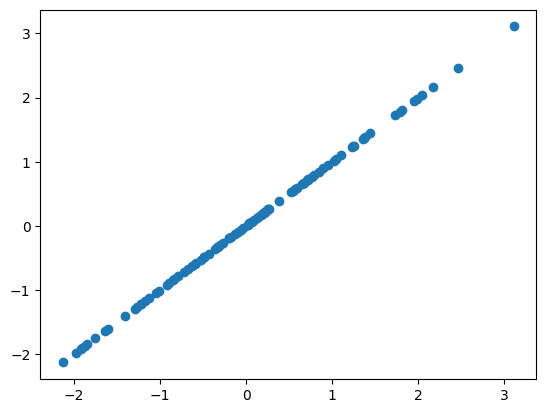

In [80]:
x = tf.random.normal(shape=(100, 1))
x_act = tf.keras.activations.linear(x)

plt.plot(x, x_act, 'o')

- Sigmoid activation

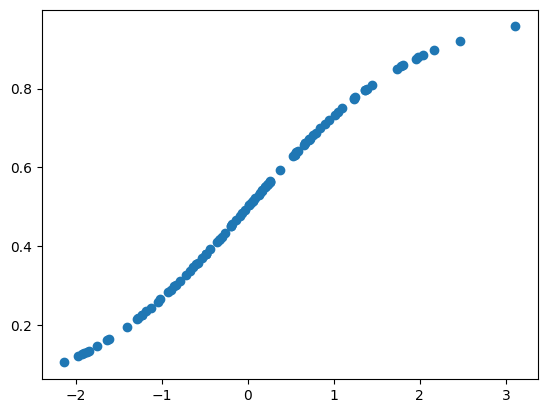

In [81]:
x_act = tf.keras.activations.sigmoid(x)

plt.plot(x, x_act, 'o')

- ReLu activation. This is a widely used activation function in deep learning, which sets all output below zero to zero, and uses a linear transform for the values above 0

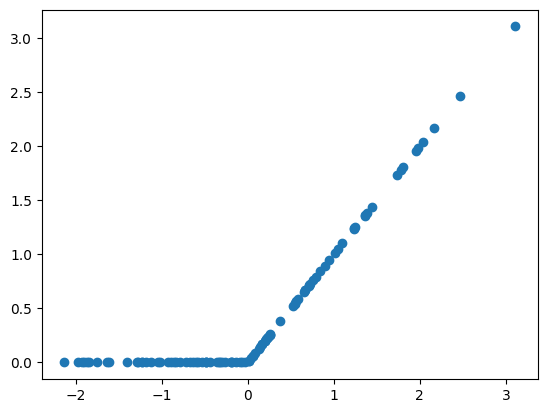

In [82]:
x_act = tf.keras.activations.relu(x)

plt.plot(x, x_act, 'o')

These functions can then be wrapped together to make a simple neural network function that describes the full forward pass (note that the `@tf.function` line compiles this so that it will run much faster than the original Python code)

In [83]:
@tf.function
def dense(inputs, W, b):
    return tf.nn.relu(tf.matmul(inputs, W) + b)

3. Backpropagation

Following the forward pass, neural networks are trained using backpropagation. In this step, a gradient is calculated for each weight relatively to the loss or error. This gradient tells the network how much to update each weight (steep gradients mean that the error is large and a larger update is needed), as well as the direction of change (positive or negative). This becomes very complicated in larger networks, where this has to be (back)propagated through multiple layers and across mulitple nodes. Tensorflow uses the concept of a gradient *tape* to help in this. This records all the necessary steps to estimate these gradients by tracking all the connections in the network. Once set up, it can then estimate the gradient of any output in the network relative to any variable or set of variables. 

To illustrate this, the following code uses a simple model of $y = 2 \times x + 3$. This is used to create a `GradientTape` object, and then we can estimate the gradient for `y` with respect to `x`. As this is just a simple linear model, the gradient is, of course, the slope of 2:

In [84]:
x = tf.Variable(0.)
with tf.GradientTape() as tape:
  y = 2 * x + 3

grad_of_y_wrt_x = tape.gradient(y, x)
grad_of_y_wrt_x

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

# Putting it together: a linear classifier

We'll now illustrate how all of this comes together with a really simple example. This is a dataset with two features (`x1` and `x2`) and a binary target (`class`):

In [85]:
df = pd.read_csv("./datafiles/slc.csv")
df.head()

,x1,x2,class
0,0.766010,1.984742,neg
1,-0.143333,2.976064,neg
2,0.866285,2.447990,neg
3,1.344657,4.420691,neg
4,-0.060448,2.278719,neg


As tensorflow really wants values as an array, we'll create two of these, one for the features (`inputs`) and one for the targets:

In [86]:
inputs = np.column_stack((df['x1'], df['x2'])).astype(np.float32)
inputs.shape

(2000, 2)

In [87]:
targets = np.where(df['class'] == 'neg', 0., 1.).astype(np.float32)
targets = targets[:,np.newaxis]

Let's plot these out to see the distribution:

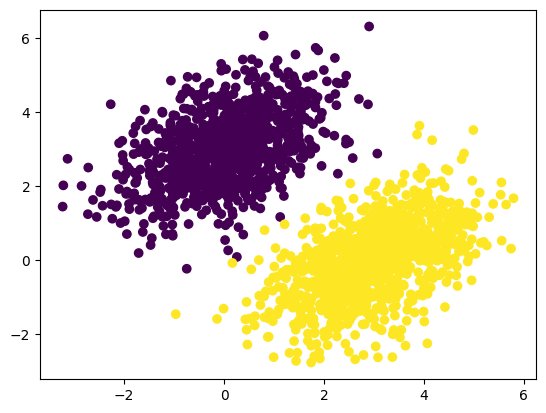

In [88]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:,0])
plt.show()

From the plot, you should be able to already visualize where you would place a line to separate the two groups. We'll now create a linear classifier that can find this line as the following equation (if you look closely, you'll see that this is just a linear model with slopes (`W`) and intercept (`b`)). 

$$
prediction = W \times input + b
$$

This is trained to minimize the square of the difference between predictions and the targets. We'll initialize values for `W` and `b` to random values and zeros, respectively.

In [89]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

As we have two inputs, `W` is just two scalar coefficients, `w1` and `w2`. `b` is a single scalar coefficient representing the intercept. So the full, expanded model is:

$$
prediction = [w_1,w_2] \times [x_1, x_2] + b = w_1 \times x_1 + w_2 \times x_2 + b
$$


Let's create a function that performs a forward pass by calculating the above equation (note this uses the `matmul` function to get the weighted output). Normally, this would use a sigmoid activation function as the outcome is binary, but to keep things simple, we won't transform the output. Note that we use a function to calculate this so that we can reuse this easily in the training loop below


In [90]:
def model(inputs, W, b):
    return tf.matmul(inputs, W) + b

To illustrate what this does, let's just run this with the first row of inputs:

In [91]:
input1 = inputs[1,np.newaxis]
tf_tensor = tf.convert_to_tensor(input1)
model(tf_tensor, W, b)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4176024]], dtype=float32)>

Giving the predicted value for the first observation. This is obviously with random weights, so there's really no expectation that it will be close to the actual value. Next, we need to calculate how close it is through a loss function. For this example, we'll use a simple mean squared error, and we'll create a function to calculate that:

In [92]:
def mean_squared_error(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

Now let's put these together with the gradient tape function to calculate the update to the weights through backpropagation. In this function, it uses the `GradientTape` to store the results of the forward pass and loss calculation. Then the tape is used to get the gradients or derivatives of the weights relative to the loss. Finally, the update is calculated by multiplying the gradient by a learning rate. This is a value less than one, which limits the update at each step. 

In [93]:
learning_rate = 0.1

@tf.function(jit_compile=True)
def training_step(inputs, targets, W, b):
    with tf.GradientTape() as tape:
        predictions = model(inputs, W, b)
        loss = mean_squared_error(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

After all that preparation, we're ready to train the model. We convert the inputs to a tensor, then run a loop 40 times, each time calling the `training_step` function to update the weights

In [94]:
for step in range(40):
    loss = training_step(inputs, targets, W, b)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.3657
Loss at step 1: 0.0840
Loss at step 2: 0.0788
Loss at step 3: 0.0742
Loss at step 4: 0.0700
Loss at step 5: 0.0661
Loss at step 6: 0.0626
Loss at step 7: 0.0594
Loss at step 8: 0.0565
Loss at step 9: 0.0538
Loss at step 10: 0.0514
Loss at step 11: 0.0491
Loss at step 12: 0.0471
Loss at step 13: 0.0452
Loss at step 14: 0.0436
Loss at step 15: 0.0420
Loss at step 16: 0.0406
Loss at step 17: 0.0393
Loss at step 18: 0.0382
Loss at step 19: 0.0371
Loss at step 20: 0.0361
Loss at step 21: 0.0352
Loss at step 22: 0.0344
Loss at step 23: 0.0337
Loss at step 24: 0.0330
Loss at step 25: 0.0324
Loss at step 26: 0.0318
Loss at step 27: 0.0313
Loss at step 28: 0.0309
Loss at step 29: 0.0304
Loss at step 30: 0.0300
Loss at step 31: 0.0297
Loss at step 32: 0.0294
Loss at step 33: 0.0291
Loss at step 34: 0.0288
Loss at step 35: 0.0285
Loss at step 36: 0.0283
Loss at step 37: 0.0281
Loss at step 38: 0.0279
Loss at step 39: 0.0278


Once trained, we can predict for each of the original observations and plot the predicted values. We'll use a simple threshold of 0.5 (i.e. predictions above 0.5 are classed as `1`, below 0.5 as `0`). We can also plot the classifier by using the trained values of `W` and `b` to get the slope and intercept:

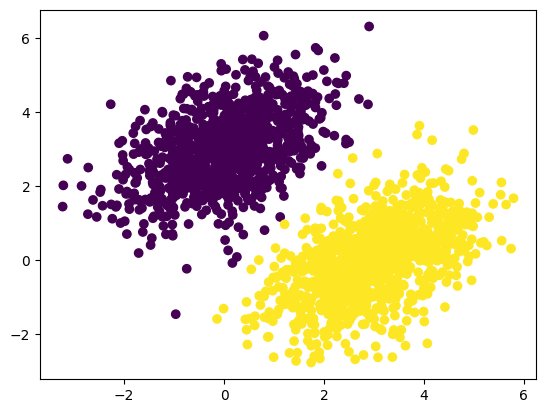

In [95]:
predictions = model(inputs, W, b)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

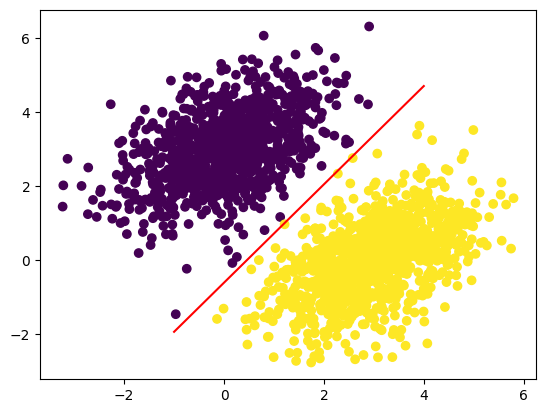

In [96]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

# The **keras** API

The examples above show how to work with the low-level **tensorflow** interface. In practice, you can skip a lot of the detail by using the **keras** API. In the code below, we'll build a multi-layer neural network to perform a classification exercise. 

## Keras workflow

Building a deep learning model through Keras requires a series of steps:

1. Create training data as tensors. This should include the input features and the target as separate tensors. For the simple models we are looking at in this lab, this is fairly straightforward, but for the more complex models, careful attention is required to the size and shape of these tensors.
2. Create the network architecture. This consists of the set of layers that link the inputs to the target(s)
3. Define the loss function, the optimizer and the performance metrics to be used to test the progress of the training
4. Train the model using the training data, with part of the training data left out as validation data

## Dataset

The data are from the file *credit_data.csv*, and represent a number of bank clients who have been tagged as having good or bad credit. The goal is to use the other variables in the file to predict this. Let's start by reading in the data. 


In [97]:
df = pd.read_csv("./datafiles/credit_data.csv")
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,good,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910


In [98]:
df.shape

(4454, 14)

There are about 4400 observations in the set, and a number of these have missing values. We'll use the **pandas** `dropna` function to remove all rows with missing values. 


In [99]:
df = df.dropna()
df.shape

(4039, 14)

Next we'll create the usual arrays of features (`X`) and targets (`y`). We'll use a conditional statement (`==`) to convert the original credit status (`good` or `bad`) to 1's and 0's

In [100]:
X = df.drop('Status', axis=1)

y = (df['Status'] == 'good').astype(int)

And we'll one hot encode or dummy transform all the categorical variables with `get_dummies`. 

In [101]:
X = pd.get_dummies(X, drop_first=True, dtype='int')

As a final preprocessing step, we'll also normalize all variables to the same range using `StandardScaler` (this subtracts the mean and divides by the standard deviation). Neural networks are *very* sensitive to the range of values, so it is standard practice to transform data to $z$-scores (as here) or to a 0-1 range.

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

Let's now split the data into the usual training and testing subsets using an 80/20 split:

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Next, we'll split the training data into training and validation. Validation datasets are important in deep learning as the complex networks can quickly and easily overfit to the training data. Validation data are used during the training process. Following each adjustment of the weights, the network predicts the labels for the validation set, and a validation error is calculated. A decreasing validation error suggests that the model is training well to the data, but when it starts to increase, this indicates overfitting: prediction for new data becomes worse. Here, we'll remove a random sample of 20% of the original training data for validation, and use the other 80% for training.

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)

In [105]:
print(f"Training size {X_train.shape}")
print(f"Validation size {X_valid.shape}")
print(f"Testing size {X_test.shape}")

Training size (2584, 22)
Validation size (647, 22)
Testing size (808, 22)


## Model architecture

### Defining the network architecture

Now we'll turn to designing the model. The first step is to create the architecture. **keras** has two methods to create the network. The simplest is to use the `Sequential()` function. This takes as input the definition of the hidden layers, as well as any parameters that are used to modify these during training. 

For example, to create a simple, two layer model with a single output, one hidden layer with 10 nodes, you would run the following command. Note that the first function takes the argument `shape` which describes the expected shape of the tensor holding the features (here 20 input features), and that we specify a ReLU activation function for the output from both layers. 

In [106]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    keras.Input(shape=(20,)), 
    layers.Dense(10, activation="relu"),
    layers.Dense(1, activation="relu")
])

model

<Sequential name=sequential_1, built=True>

The basic layer used here is a *dense* layer. This is one where every node connects to each incoming input and to each output. In this case, each of the twenty input features would connect to the 10 nodes in the hidden layer, and each of those will connect to the single output node. Each of these connections will have a weight to it, as well as a bias added to each node. Overall this gives us $20 \times 10 + 10 = 210$ from the input to the hidden layer, and $10 \times 1 + 1 = 11$, giving 221 parameters overall. To check this we can use the `summary` function with the model object, which gives an overview of the model architecture. You'll see that it has automatically named each layer (e.g. `dense_1`) as well as the overall model (you can add names if useful). 

In [107]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221 (884.00 B)

 Trainable params: 221 (884.00 B)

 Non-trainable params: 0 (0.00 B)

YOu can also plot out the network architecture using `plot_model`. Note that this requires two additional libraries (`pydot` and `graphviz`) to be installed. You may also need the graphviz executables - please ask if you need help with this.

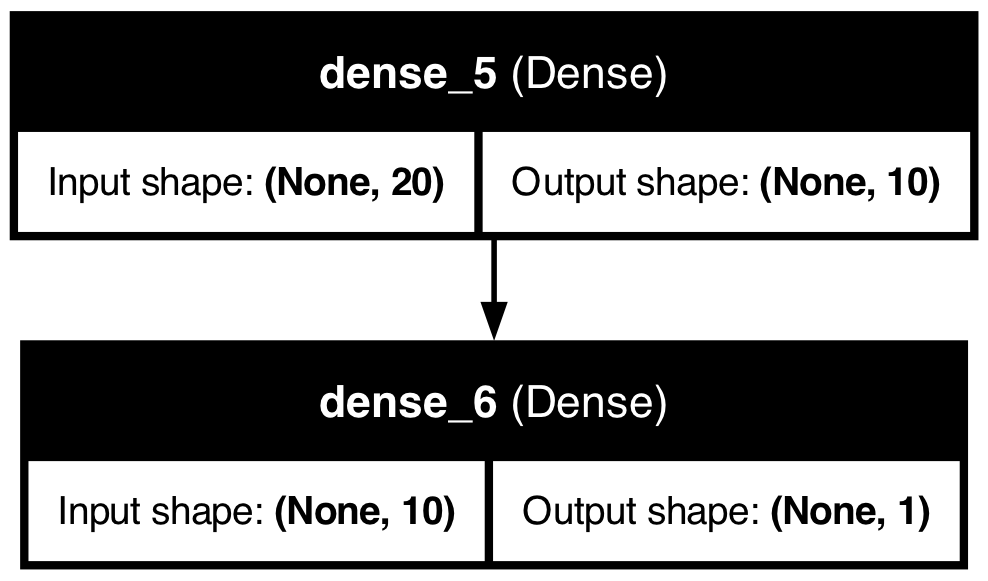

In [108]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

The other method to define the architecture uses the Keras API. This is a much more flexible approach based on graph theory and can be used to create networks that are much more complex. 

For our model, we'll create something a little more complex. This will have two hidden layers, each with 256 nodes. The final layer will give the prediction. As we only need to predict one thing (the credit risk), we only need one node. We'll use ReLu activation functions throughout, except for the final layer where we use a sigmoid activation function to constrain the output to the range [0-1]. 

We'll add a couple of dropout layers as well. These are layers where a proportion of the weights are set to zero, effectively removing them from any prediction. This has the effect of penalizing the model, making it slower to train, but reducing the risk of overfitting.

In [109]:
model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)), 
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
], name = "credit_model")

model.summary()

Model: "credit_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,937 (281.00 KB)

 Trainable params: 71,937 (281.00 KB)

 Non-trainable params: 0 (0.00 B)

Note that the increase in the number of layers and nodes has had a large effect in the total number of parameters to be estimated, now at around 71,000 parameters.

Next, we'll define the list of metrics to be calculated during training. We'll just record the accuracy, but you can add further metrics here (see the help documentation for a full list). 


In [110]:
metrics = ['accuracy']

Next, we need to compile the model. This links the model to a specific optimizer, the loss function and any error metrics we want to calculate. 

- Optimizer: We'll use the standard backpropagation algorithm here (`rmsprop`), with a learning rate of 1e-4. This is controls the amount of update for each weight at each iteration. Other optimizers include `sgd` for stochastic gradient descent and `adam` for the Adam algorithm, both of which are useful for much larger, complex data
- Loss function. Here, we'll use binary cross entropy. This is the standard loss function for binary outcomes (cross entropy is a measure of how different two distributions are, and this is well suited to a binary classification exercise, where we want to discriminate between 0's and 1's)
- Metrics: we simply include the list we made earlier



In [111]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=metrics)

Now we have everything in place, we can train the model. Here we specify:

- the set of features for training (`train_features`)
- the set of labels for training (`train_targets`)
- the number of iterations to train the model for (`epochs`)
- the `batch_size`. 
- the validation features and labels

The batch size is quite an useful parameter to make your network more efficient. This is the number of samples to pass through the network before updating weights. This allows you to trade off the speed of the calculation against the convergence. Using smaller batches uses less memory but may take longer to converge, as the weights are being updated using only a fraction of the data. Larger batches will converge quickly, by may cause memory issues, and may more easily result in overfitting. 


In [112]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=30,
                    batch_size=256
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6488 - loss: 0.6640 - val_accuracy: 0.7512 - val_loss: 0.6128
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7374 - loss: 0.6110 - val_accuracy: 0.7512 - val_loss: 0.5833
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7419 - loss: 0.5912 - val_accuracy: 0.7512 - val_loss: 0.5619
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7470 - loss: 0.5659 - val_accuracy: 0.7512 - val_loss: 0.5435
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7563 - loss: 0.5423 - val_accuracy: 0.7543 - val_loss: 0.5263
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7508 - loss: 0.5382 - val_accuracy: 0.7543 - val_loss: 0.5122
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7512 - loss: 0.5279 - val_accuracy: 0.7589 - val_loss: 0.4996
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7618 - loss: 0.5120 - val_accuracy: 0.7573 - val_loss:

As the model runs, you'll see some output showing the loss anc accuracy during the training. Pay attention to changes in the loss (which should decrease) and the accuracy (which should increase). Note that there are values for the training and for the validation set. 

These results are also stored in the `history` object, which we can then plot:


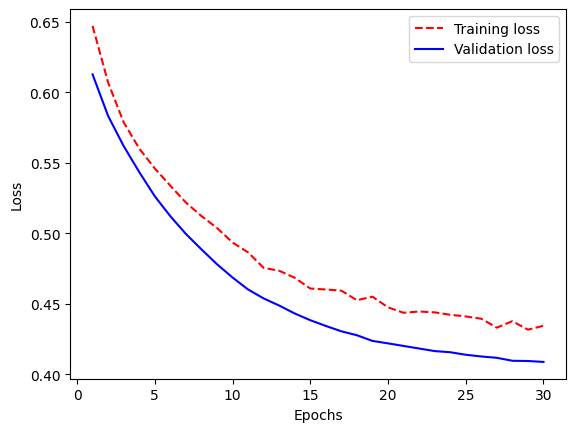

In [113]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

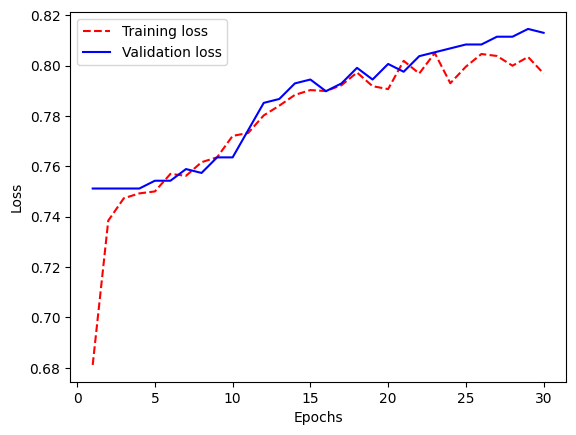

In [114]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "r--", label="Training loss")
plt.plot(epochs, val_accuracy, "b", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

These show an expected decrease in loss, and corresponding increase in accuracy for both the training and validation sets. Note that the validation loss continues to decline, which may suggest that further training would be useful.

We can test the model by using the `predict` function and the test (not validation!) dataset. 

In [115]:
y_test_pred = model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


As the predictions are probabilities [0-1], we'll now convert these to binary [0,1] and calculate the accuracy:

In [116]:
y_test_pred = np.where(y_test_pred > 0.5, 1, 0)

In [117]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred[:,0])

array([[ 80, 130],
       [ 40, 558]])

In [118]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_pred[:,0])

0.7896039603960396

We get an accuracy of about 0.8, which is not bad for a first attempt. The next steps would be to modify the network architecture to see if this could be improved on, e.g. by adding more layers or more nodes in the layers. 

# Exercise

For the exercise, you just need to make a new model for the credit score data. There are several things that you can try, including:

- Adding more layers
- Adding more nodes
- Changing the learning rate, batch size or number of training epochs

Use a new notebook to record the code describing the changes in your model setup. You should also re-train the model and make a new set of predictions for the test set, and report the accuracy. These should be submitted to Canvas by March 31st. Please use the following naming convention: `Lab07_lastname.ipynb`.

# Appendix

## Credit risk data set

*credit_data.csv*

| Column header     | Variable                           |
|-------------------|------------------------------------|
| `Status`         | whether the customer managed to pay back the loan (0) or not (1)                       |
| `Seniority`            | job experience in years                               |
| `Home`             | type of homeownership: renting (1), a homeowner (2), and others                         |
| `Time` | period planned for the loan (in months) |
| `Age`       | age of the client                      |
| `Marital`     | marital [status]: single (1), married (2), and others          |
| `Records`          | whether the client has any previous records: no (1), yes (2)                  |
| `Job` | type of job: full-time (1), part-time (2), and others              |
| `Expenses`      | how much the client spends per month                  |
| `Income`      | how much the client earns per month                    |
| `Assets`      | total worth of all the assets of the client                    |
| `Debt`      | amount of credit debt                   |
| `Amount`      | requested amount of the loan                    |
| `Price`      | price of an item the client wants to buy                   |
